# Correlations and relationships between movements

In [1]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats
from scipy import signal

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_ME, get_raw_and_smooth_position, get_ME, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin


In [2]:
one = ONE()

In [3]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
#data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))
example_session = 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9'
example_session = 'b39752db-abdb-47ab-ae78-e8608bbf50ed'

## Correlation between pupil size and wheel movement

In [4]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'

### Session-specific data

In [31]:
# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = prepro(session_trials.to_df())

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

# Pupil diameter
pupil_dia_raw, pupil_dia_smooth, _, _ = (
    get_raw_and_smooth_position(example_session, video_type, ephys=True, position_function=get_pupil_diameter))
pupil_t, XYs = get_dlc_XYs(example_session, view=video_type, likelihood_thresh=0.9)

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.50M/7.50M [00:03<00:00, 2.32MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.50M/7.50M [00:03<00:00, 2.03MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [32]:
session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']

# Initialize dataframe
wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


In [33]:
# Merge data
all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

# Remove wheel disp (was used just to get onset times alignment with bins)
data_df = all_metrics.dropna().drop_duplicates()
data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

### Plot pupil diameter and wheel speed

/tmp/ipykernel_32209/2010342594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Bin'] = use_data['Bin'] / 10


Text(0.5, 1.0, 'b39752db-abdb-47ab-ae78-e8608bbf50ed')

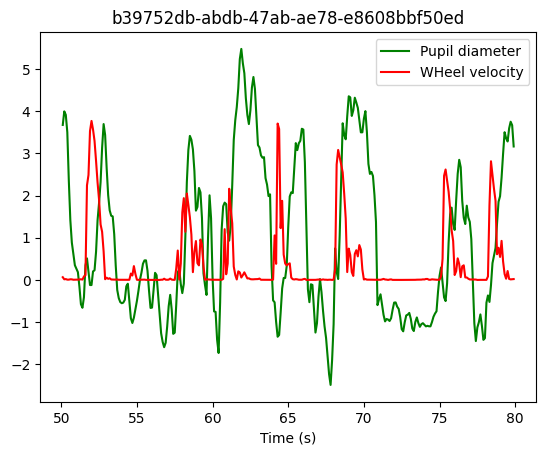

In [44]:
use_data = data_df.loc[(data_df['Bin']<800) & (data_df['Bin']>500)]
use_data['Bin'] = use_data['Bin'] / 10

plt.plot(use_data['Bin'], use_data['pupil_diameter'], color='green', label='Pupil diameter')
plt.plot(use_data['Bin'], np.abs(use_data['avg_wheel_vel']), color='red', label='WHeel velocity')
plt.legend()
plt.xlabel('Time (s)')
plt.title(example_session)


#sns.lineplot(x='Bin', y='pupil_diameter', data=use_data)

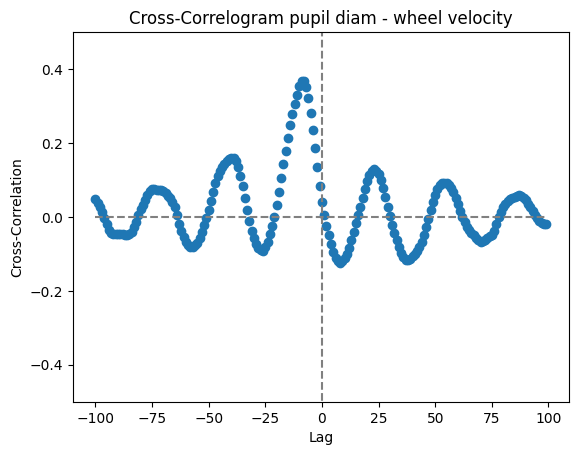

In [45]:
x = data_df['pupil_diameter']
y = data_df['avg_wheel_vel']

# Calculate the lag values corresponding to the cross-correlation
lags = np.arange(-100, 100)

# Compute the cross-correlation using np.correlate
cross_correlation = np.zeros(len(lags)) * np.nan
len_timeseries = len(x)
for l, lag in enumerate(lags):
    if lag < 0:
        x_chunk = np.array(x[-lag:])
        y_chunk = np.array(y[:lag])
    elif lag == 0:
        x_chunk = np.array(x)
        y_chunk = np.array(y)
    elif lag > 0:
        x_chunk = np.array(x[0:-lag])
        y_chunk = np.array(y[lag:])
    cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
    #np.sum(x_chunk * y[lag-lag:len(x_chunk)]) / ((len_timeseries-lag)* np.std(x_chunk) * np.std(y[lag-lag:len(x_chunk)]))

# Plot the cross-correlation
import matplotlib.pyplot as plt
plt.scatter(lags, cross_correlation)
plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
plt.vlines(0, -1, 1, color='gray', linestyles='--')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlogram pupil diam - wheel velocity')
plt.ylim([-.5, .5])
plt.show()

### Plot wheel velocity per pupil size bin

In [86]:
# Bin data on both axes
bin_edges = np.arange(-50, 50, 2.5)
data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges, labels=bin_edges[:-1])

(15.0, 24.0)

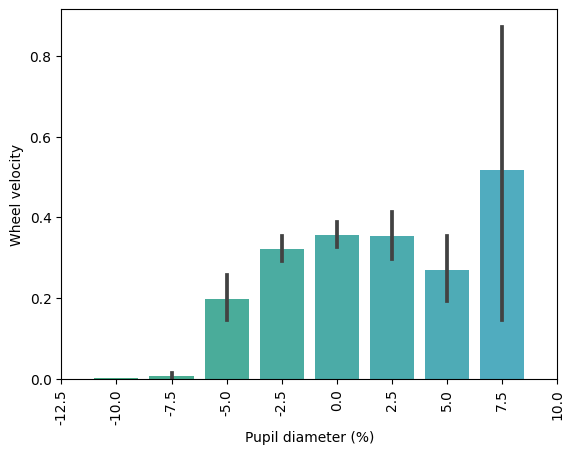

In [88]:
# Plot
sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
plt.xlabel('Pupil diameter (%)')
plt.ylabel('Wheel velocity')
plt.xticks(rotation=90)
b = np.arange(0, len(bin_edges), 1)
min = b[np.where(bin_edges==np.min(data_df['pupil_bin']))][0]
max = b[np.where(bin_edges==np.max(data_df['pupil_bin']))][0]
plt.xlim([min-1, max+1])


### Plot with lag corresponding to maximum correlation

In [89]:
max_corr = lags[np.where(cross_correlation==np.max(cross_correlation))][0]
max_corr

-9

### Shift data to get maximum correlation

In [85]:
# Shorten data frame in order to shift variables according to the maximum correlation lag

x = data_df['pupil_diameter']
y = data_df['avg_wheel_vel']
lag = max_corr
if max_corr < 0:
    x_chunk = np.array(x[-lag:])
    y_chunk = np.array(y[:lag])
    short_df = data_df[-lag:]
    short_df['x'] = x_chunk
    short_df['y'] = y_chunk
elif max_corr == 0:
    x_chunk = np.array(x)
    y_chunk = np.array(y)
    short_df = data_df.copy()
elif max_corr > 0:
    x_chunk = np.array(x[0:-lag])
    y_chunk = np.array(y[0:-lag])
    short_df = data_df[-lag:]
    short_df['x'] = x_chunk
    short_df['y'] = y_chunk

/tmp/ipykernel_32209/811261269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['x'] = x_chunk
/tmp/ipykernel_32209/811261269.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['y'] = y_chunk


In [92]:
# Bin data on both axes
bin_edges = np.arange(-50, 50, 2.5)
short_df['pupil_bin'] = pd.cut(short_df['pupil_diameter'], bins=bin_edges, labels=bin_edges[:-1])

/tmp/ipykernel_32209/868204677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['pupil_bin'] = pd.cut(short_df['pupil_diameter'], bins=bin_edges, labels=bin_edges[:-1])


(15.0, 24.0)

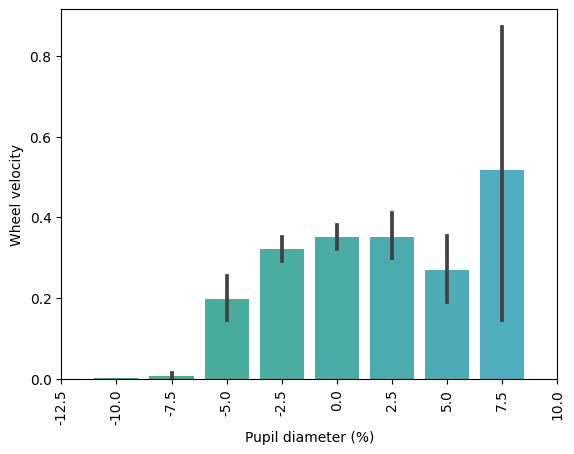

In [93]:
# Plot
sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=short_df)  # 
plt.xlabel('Pupil diameter (%)')
plt.ylabel('Wheel velocity')
plt.xticks(rotation=90)
b = np.arange(0, len(bin_edges), 1)
min = b[np.where(bin_edges==np.min(short_df['pupil_bin']))][0]
max = b[np.where(bin_edges==np.max(short_df['pupil_bin']))][0]
plt.xlim([min-1, max+1])


## Relationship between reaction/response/consumption time and ME peak

In [5]:
def align_stimOn(df, trials):

    # Define the bin edges array
    trial_edges = list(trials['stimOn_times'])

    onsets = pd.DataFrame({'onset_times': trial_edges,
                          'Trial': np.arange(0, len(trial_edges), 1)})
    
    # Merge dataframes
    df = df.merge(onsets, on='Trial')
        
    return df


In [6]:
# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = prepro(session_trials.to_df())

# Motion energy of whisker pad
me_times, motion_energy = get_ME(example_session, video_type)
X_center0, smooth_me, _, _ = get_raw_and_smooth_ME(motion_energy, video_type='left', ephys=True)       
smooth_me = zscore(smooth_me, nan_policy='omit') 

In [26]:
session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']
event = 'stimOn_times'
t_init = 0.5
t_end = 10

# Align on stimulus onset
me_aligned = timeseries_PSTH(me_times, smooth_me, session_trials, event, t_init, t_end, subtract_baseline=False)
#me_aligned['value'] = me_aligned['value'].rolling(3).mean()

# Get peak of
max_ME = pd.DataFrame(me_aligned.groupby(['feedback_time'])['value'].max())
max_ME = max_ME.reset_index(level=[0])
max_ME = max_ME.rename(columns={'value':'max_ME'})

merged = me_aligned.merge(max_ME, on='feedback_time', how='inner')
reduced = merged.loc[merged['value']==merged['max_ME']]


Text(0, 0.5, 'Z-scored Motion energy')

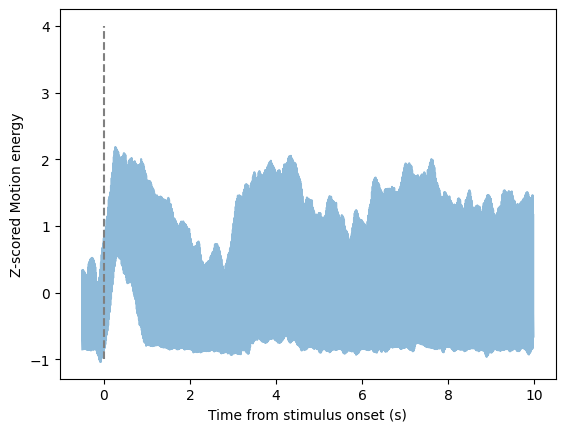

In [24]:
use_data = me_aligned.loc[me_aligned['feedback_time']< 0.5]
use_data = use_data.rolling(3).mean()
sns.lineplot(x='variable', y='value', data=use_data, estimator=None, alpha=0.5)
plt.vlines(0, -1, 4, color='grey', linestyles='--')
plt.xlabel('Time from stimulus onset (s)')
plt.ylabel('Z-scored Motion energy')


0.09349850774387386

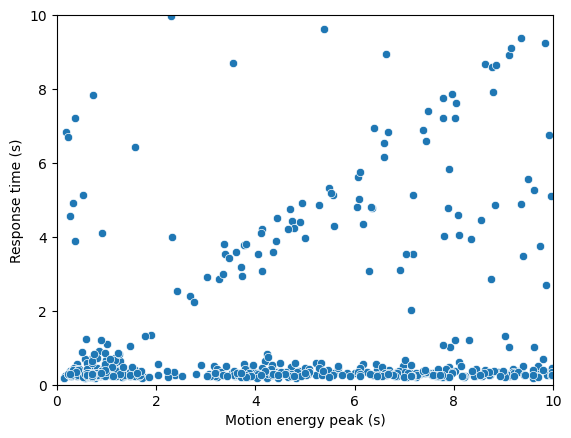

In [27]:
# Find maximum ME for each trial
smooth = reduced.copy()
sns.scatterplot(x='variable', y='response_time', data=reduced)
plt.ylim([0,t_end])
plt.xlim([0,t_end])
plt.xlabel('Motion energy peak (s)')
plt.ylabel('Response time (s)')
stats.pearsonr(reduced['variable'], reduced['response_time']).statistic

0.0030476234659145914

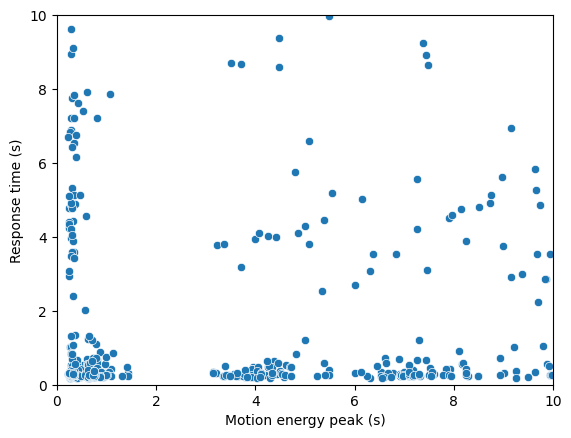

In [25]:
# Find maximum ME for each trial
smooth = reduced.copy()
sns.scatterplot(x='variable', y='response_time', data=reduced)
plt.ylim([0,t_end])
plt.xlim([0,t_end])
plt.xlabel('Motion energy peak (s)')
plt.ylabel('Response time (s)')
stats.pearsonr(reduced['variable'], reduced['response_time']).statistic

0.09350717601076622

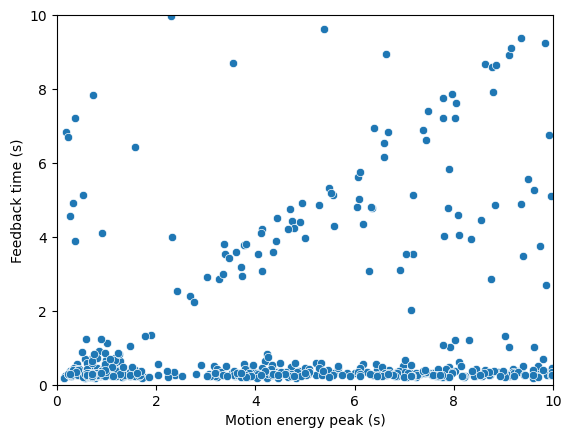

In [28]:
# Plot correlation with feedback time

sns.scatterplot(x='variable', y='feedback_time', data=reduced)
plt.ylim([0,t_end])
plt.xlim([0,t_end])
plt.xlabel('Motion energy peak (s)')
plt.ylabel('Feedback time (s)')
stats.pearsonr(reduced['variable'], reduced['feedback_time']).statistic

Text(0, 0.5, 'Z-scored Motion energy')

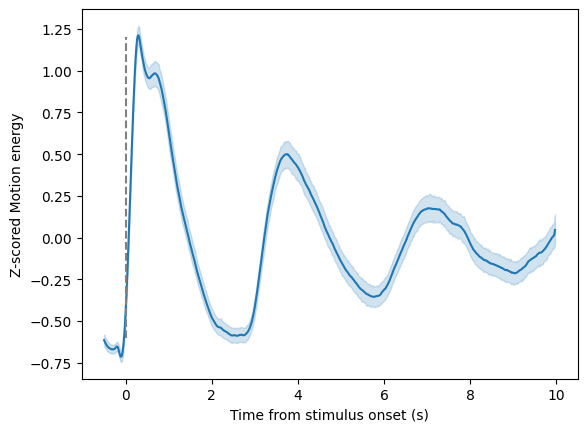

In [11]:
sns.lineplot(x='variable', y='value', data=me_aligned)
plt.vlines(0, -0.6, 1.2, color='grey', linestyles='--')
plt.xlabel('Time from stimulus onset (s)')
plt.ylabel('Z-scored Motion energy')